<a href="https://colab.research.google.com/github/OrionDB5/imageCaptioning/blob/main/imageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
import string
import numpy as np
import pandas as pd 
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import keras
import sys, time, warnings 
warnings.filterwarnings("ignore")
import re

import tensorflow as tf
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
import os
import json
import zipfile

!pip install kaggle
api_token = {"username":"davidebelgenio","key":"0382d5592fe509c8b19c2eafbd24878d"}
!mkdir -p ~/.kaggle
with open('kaggle.json', 'w') as file:
    json.dump(api_token, file)
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
#!kaggle datasets download -d dibyansudiptiman/flickr-8k
!kaggle datasets download -d ming666/flicker8k-dataset

zip_ref = zipfile.ZipFile("./flicker8k-dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

kaggle.json
flicker8k-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
image_path = "Flickr8k_Dataset/Flicker8k_Dataset/"
dir_Flickr_text = "Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16091


In [ ]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
#data = data[data['filename'] != '2258277193_586949ec62.jpg.1']


uni_filenames = np.unique(data.filename.values)
data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [ ]:
data['split'] = np.nan
data.head()

,index,filename,caption,split
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...,NaN
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .,NaN
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .,NaN
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...,NaN
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...,NaN


In [ ]:
train_filenames = pd.read_csv('Flickr8k_text/Flickr_8k.trainImages.txt', sep='\n', names=['filename'])
val_filenames = pd.read_csv('Flickr8k_text/Flickr_8k.devImages.txt', sep='\n', names=['filename'])
test_filenames = pd.read_csv('Flickr8k_text/Flickr_8k.testImages.txt', sep='\n', names=['filename'])

In [ ]:
data.loc[data['filename'].isin(train_filenames['filename']), 'split'] = 'train'
data.loc[data['filename'].isin(val_filenames['filename']), 'split'] = 'val'
data.loc[data['filename'].isin(test_filenames['filename']), 'split'] = 'test'

# drop anything which is not in any split
data = data.dropna()

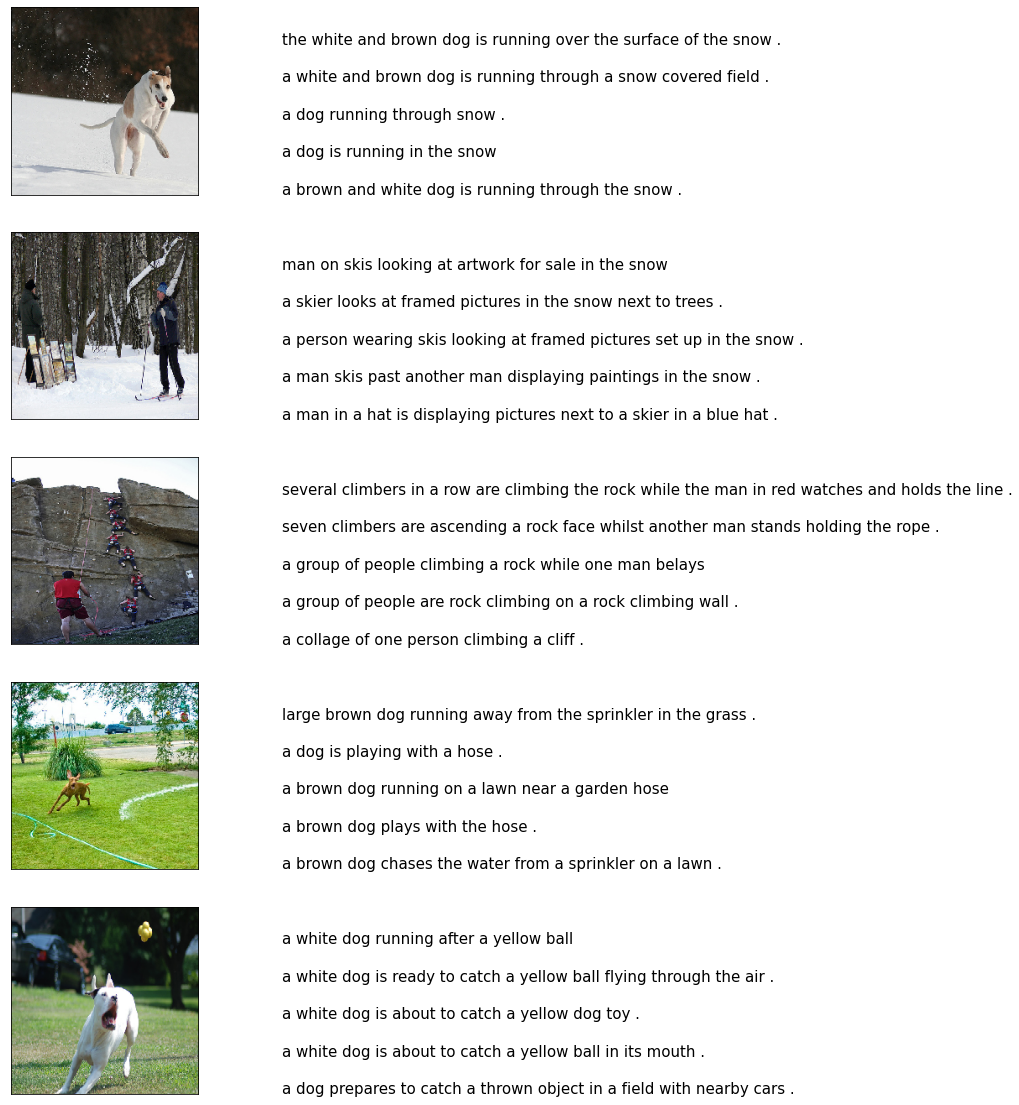

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"] == jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)
    count += 1
plt.show()

In [ ]:
vocabulary = []
for txt in data.loc[data['split'] == 'train'].caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 7705


In [ ]:
img = data["filename"].tolist()
caption = data["caption"].tolist()

In [ ]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 40000
len(caption) : 40000


In [ ]:
# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [ ]:
def text_clean(text_original):
    text = remove_single_character(text_original)
    text = remove_numeric(text)
    return text

data.caption = data.caption.apply(text_clean)

In [ ]:
clean_vocabulary = []
for txt in data.loc[data['split'] == 'train'].caption.values:
    clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 7263


In [ ]:
def extract_captions(df, split) : 
  captions = []
  for caption  in df.loc[df['split'] == split, 'caption'].astype(str):
      caption = '<start> ' + caption + ' <end>'
      captions.append(caption)  
  return captions

def extract_img_paths(base_path, df, split) : 
  img_paths = []
  for annot in df.loc[df['split'] == split, "filename"]:
      full_image_path = base_path + annot
      img_paths.append(full_image_path)  
  return img_paths

In [ ]:
train_captions = extract_captions(data, 'train')
val_captions = extract_captions(data, 'val')
test_captions = extract_captions(data, 'test')

train_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [ ]:
train_img_paths = extract_img_paths(image_path, data, 'train')
val_img_paths = extract_img_paths(image_path, data, 'val')
test_img_paths = extract_img_paths(image_path, data, 'test')

train_img_paths[:10]

['Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

In [ ]:
def data_limiter(num, captions, img_paths):
  
  if num == None :
    return shuffle(captions, img_paths, random_state=42)
  
  lim_captions, lim_img_paths = shuffle(captions, img_paths, random_state=42)
  lim_captions = lim_captions[:num]
  lim_img_paths = lim_img_paths[:num]

  return lim_captions, lim_img_paths

In [ ]:
train_captions, train_img_paths = data_limiter(None, train_captions, train_img_paths)

In [ ]:
print(f"Number of images for training: {len(set(train_img_paths))}")
print(f"Number of cations for training: {len(train_captions)}")

Number of images for training: 6000
Number of cations for training: 30000


Let’s define the image feature extraction model using InceptionV3. We must remember that we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the model. We must all preprocess all the images to the same size, i.e, 299×299 before feeding them into the model, and the shape of the output of this layer is 8x8x2048.

In [ ]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.trainable = False

Next, let’s Map each image name to the function to load the image. We will pre-process each image with InceptionV3 and cache the output to disk and image features are reshaped to 64×2048.

In [ ]:
# Get unique images
encode_train = sorted(set(train_img_paths +
                          val_img_paths + 
                          test_img_paths))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Here we are extracting the features
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 500/500 [01:54<00:00,  4.36it/s]


## Preprocess and tokenize the captions

Next, we tokenize the captions and build a vocabulary of all the unique words in the data. We will also limit the vocabulary size to the top 5000 words to save memory. We will replace words not in vocabulary with the token < unk >

In [ ]:
top_k = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
val_seqs = tokenizer.texts_to_sequences(val_captions)
test_seqs = tokenizer.texts_to_sequences(test_captions)

In [ ]:
max_cap_len = max(len(x) for x in train_seqs + val_seqs + test_seqs)

In [ ]:
train_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=max_cap_len, padding='post')
val_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, maxlen=max_cap_len, padding='post')
test_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=max_cap_len, padding='post')

val_cap_vector.shape

(5000, 33)

## Create a tf.data.Dataset for training and validation

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(train_img_paths) // BATCH_SIZE

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((train_img_paths, train_cap_vector))

# Use map to load the numpy files in parallel
dataset_train = dataset_train.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
dataset_val = tf.data.Dataset.from_tensor_slices((val_img_paths, val_cap_vector))

# Use map to load the numpy files in parallel
dataset_val = dataset_val.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

Calculate the attention weights. q, k, v must have matching leading dimensions. k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v. The mask has different shapes depending on its type (padding or look ahead) but it must be broadcastable for addition.

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, row_size, col_size, 
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [ ]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='val_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='val_accuracy')

In [ ]:
transformer = Transformer(num_layers,  
                          d_model, 
                          num_heads, 
                          dff, 
                          row_size, 
                          col_size, 
                          target_vocab_size, 
                          max_pos_encoding=target_vocab_size, 
                          rate=dropout_rate)

In [ ]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

In [ ]:
@tf.function
def train_step(img_tensor, target):
  target_inp = target[:, :-1]
  target_real = target[:, 1:]
  
  dec_mask = create_masks_decoder(target_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, target_inp, 
                                 True,  
                                 dec_mask)
    loss = loss_function(target_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(target_real, predictions)

In [ ]:
'''This function is for forward passing features for calculating losses with no backprop'''
@tf.function
def valid_step(img_tensor, target):
  target_inp = target[:, :-1]
  target_real = target[:, 1:]
  
  dec_mask = create_masks_decoder(target_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, target_inp, 
                                 True,  
                                 dec_mask)
    loss = loss_function(target_real, predictions)
  
  val_loss(loss)
  val_accuracy(target_real, predictions)

In [ ]:
EPOCHS = 1

prev_loss = np.inf

for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (img_tensor, tar)) in enumerate(dataset_train):
    train_step(img_tensor, tar)
    
    if batch % 50 == 0:
      print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
  print('Time taken for 1 epoch: {} secs'.format(time.time() - start))



  for (batch, (img_tensor, target)) in enumerate(dataset_val):
    valid_step(img_tensor, target)

  curr_loss = val_loss.result()
  print(f"val_loss: {curr_loss} - val_accuracy: {val_accuracy.result()}" )

  #This code makes sure we only save the best val_loss score weights
  if curr_loss < prev_loss:
    prev_loss = curr_loss   # save best loss only
    print("Model improved. Saving...\n")
    transformer.save_weights('image_caption_transformer-best_weights.h5')
  else:
    print("Model didn't improve.\n")

Epoch 1 Batch 0 Loss 8.6321 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.1598 Accuracy 0.0188
Epoch 1 Batch 100 Loss 7.7602 Accuracy 0.0249
Epoch 1 Batch 150 Loss 7.4726 Accuracy 0.0272
Epoch 1 Batch 200 Loss 7.1819 Accuracy 0.0299
Epoch 1 Batch 250 Loss 6.9025 Accuracy 0.0331
Epoch 1 Batch 300 Loss 6.6608 Accuracy 0.0359
Epoch 1 Batch 350 Loss 6.4501 Accuracy 0.0393
Epoch 1 Batch 400 Loss 6.2627 Accuracy 0.0427
Epoch 1 Batch 450 Loss 6.0957 Accuracy 0.0455
Epoch 1 Loss 6.0397 Accuracy 0.0465
Time taken for 1 epoch: 187.4222903251648 secs
val_loss: 4.596402645111084 - val_accuracy: 0.07360000163316727
Model improved. Saving...



In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

NameError: ignored

In [ ]:
transformer.load_weights('image_caption_transformer-best_weights.h5')

In [ ]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output, False, dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

BLEU-1 score: 26.666666666666668
BLEU-2 score: 13.801311186847082
BLEU-3 score: 30.47559608895134
BLEU-4 score: 37.15011599826719
Real Caption: man and woman sit by small table in <unk> clothing
Predicted Caption: man in black and white and white and woman in the of black and woman


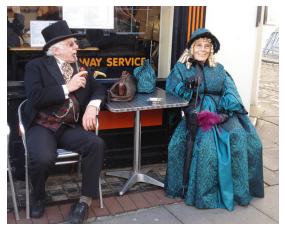

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(val_img_paths))
image = val_img_paths[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in val_cap_vector[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

In [ ]:
reference

[['two', 'people', 'walking', 'on', 'street', 'with', 'barren', 'trees']]

In [ ]:
candidate

['two', 'people', 'are', 'are', 'in', 'the', 'snow']

To summarise, Transformers are better than all the other architectures that we have seen before because they totally avoid recursion, by processing sentences as a whole and by learning relationships between words thanks to multi-head attention mechanisms and positional embeddings. It must also be pointed out that transformers using Tensorflow can capture only dependencies within the fixed input size used to train them.